In [19]:
##importing useful libaraies 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams
import multiprocessing as mp
%matplotlib inline
import math
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

import pickle
from sklearn.datasets import make_classification


In [2]:
#reading data and analyzing content information

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print(train_df.shape)
print(test_df.shape)

(404290, 6)
(2345796, 3)


In [3]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


# Analysis of training and test data

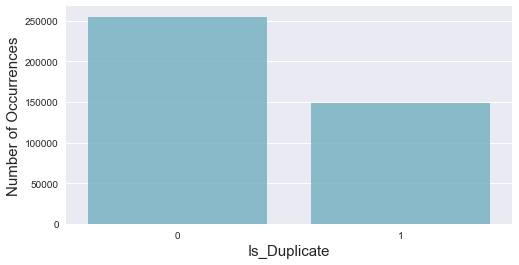

In [5]:
#Target Variable Exploration by  Bar Graph


color = sns.color_palette()

is_dup = train_df['is_duplicate'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, is_dup.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Is_Duplicate', fontsize=15)
plt.show()

In [6]:
(is_dup / is_dup.sum())*100


0    63.080215
1    36.919785
Name: is_duplicate, dtype: float64

In [7]:
##So we have about 63% non-duplicate questions and 37% duplicate questions in the training data set.

In [8]:
#Questions Exploration:


all_ques_df = pd.DataFrame(pd.concat([train_df['question1'], train_df['question2']]))
all_ques_df.columns = ["questions"]

all_ques_test_df = pd.DataFrame(pd.concat([test_df['question1'], test_df['question2']]))
all_ques_test_df.columns = ["questions"]

#Spliting of question in words

all_ques_df["num_of_words"] = all_ques_df["questions"].apply(lambda x : len(str(x).split()))

all_ques_test_df["num_of_words"] = all_ques_test_df["questions"].apply(lambda x : len(str(x).split()))



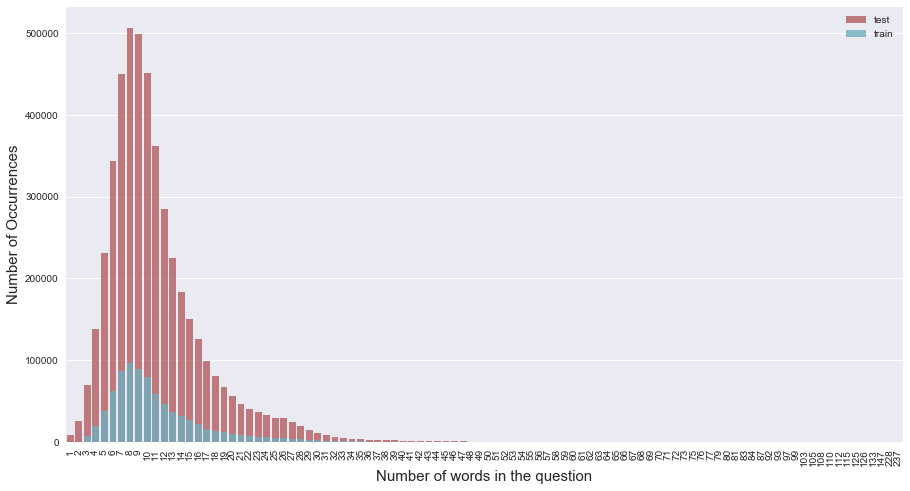

In [9]:
cnt_srs = all_ques_df['num_of_words'].value_counts()
cnt_srs_test = all_ques_test_df['num_of_words'].value_counts()

plt.figure(figsize=(15,8))
sns.barplot(cnt_srs_test.index, cnt_srs_test.values, alpha=0.8, color=color[2], label='test')
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5], label='train')


plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Number of words in the question', fontsize=15)
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [10]:
##So the distribution is right skewed with upto 237 words in a question

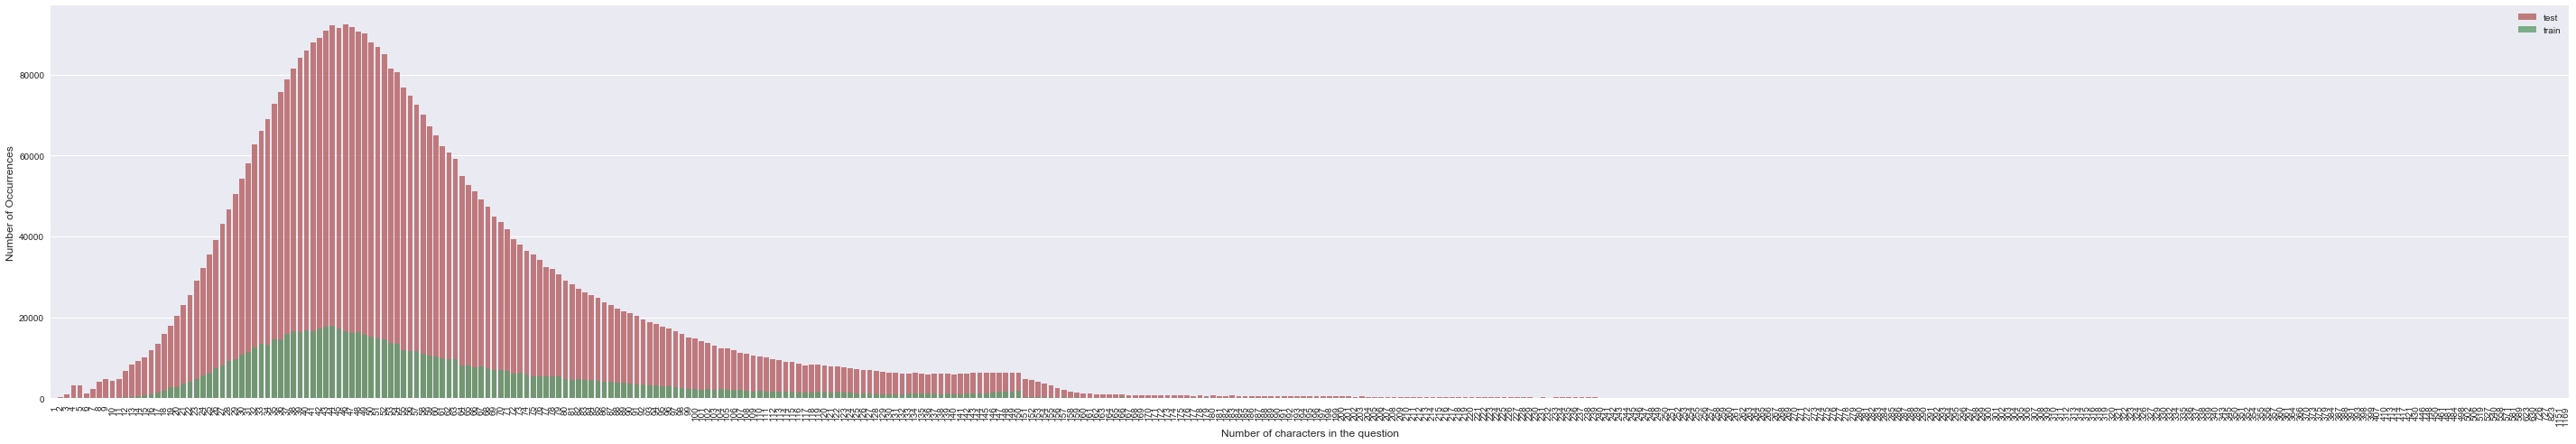

In [11]:
##number of characters distribution

all_ques_df["num_of_chars"] = all_ques_df["questions"].apply(lambda x : len(str(x)))

all_ques_test_df["num_of_chars"] = all_ques_test_df["questions"].apply(lambda x : len(str(x)))

cnt_srs = all_ques_df['num_of_chars'].value_counts()

cnt_srs_test = all_ques_test_df['num_of_chars'].value_counts()

plt.figure(figsize=(50,8))
sns.barplot(cnt_srs_test.index, cnt_srs_test.values, alpha=0.8, color=color[2],label='test')

sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1],label='train')


plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of characters in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.legend()
plt.show()      



In [12]:
#We can see that most questions have anywhere from 15 to 150 characters in them. It seems that the test distribution is a little different from the train one, but not too much so (I can't tell if it is just the larger data reducing noise, but it also seems like the distribution is a lot smoother in the test set).

#One thing that catches my eye is the steep cut-off at 150 characters for the training set, for most questions, while the test set slowly decreases after 150. Could this be some sort of Quora question size limit?

In [14]:
#There are very very few missing values.

In [5]:

from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


C:\Users\legen\Anaconda3\lib\site-packages\gensim-3.0.0-py3.6-win-amd64.egg\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Pre-Processing

In [36]:
# Tokenizing
tokenizer = RegexpTokenizer(r'\w+')

# Train
df_train = train_df.question1.append(train_df.question2).apply(lambda x: tokenizer.tokenize(str(x).lower()))
df_train.to_pickle("df_train_tokenized.pkl")

#del tokenizer, df_train
df_train

0         [what, is, the, step, by, step, guide, to, inv...
1         [what, is, the, story, of, kohinoor, koh, i, n...
2         [how, can, i, increase, the, speed, of, my, in...
3         [why, am, i, mentally, very, lonely, how, can,...
4         [which, one, dissolve, in, water, quikly, suga...
5         [astrology, i, am, a, capricorn, sun, cap, moo...
6                                   [should, i, buy, tiago]
7                     [how, can, i, be, a, good, geologist]
8                   [when, do, you, use, シ, instead, of, し]
9         [motorola, company, can, i, hack, my, charter,...
10        [method, to, find, separation, of, slits, usin...
11        [how, do, i, read, and, find, my, youtube, com...
12              [what, can, make, physics, easy, to, learn]
13        [what, was, your, first, sexual, experience, l...
14        [what, are, the, laws, to, change, your, statu...
15        [what, would, a, trump, presidency, mean, for,...
16                         [what, does, 

In [37]:
# Stopword filtering
stopset = set(stopwords.words('english'))

# Train
df = pd.read_pickle('df_train_tokenized.pkl')
df = df.apply(lambda x: [w for w in x if w not in stopset])
df.to_pickle('TRAIN_filtered.pkl')

#del stopset, df
df.head()

0    [step, step, guide, invest, share, market, india]
1                [story, kohinoor, koh, noor, diamond]
2    [increase, speed, internet, connection, using,...
3                            [mentally, lonely, solve]
4    [one, dissolve, water, quikly, sugar, salt, me...
dtype: object

In [18]:
# Stemming (with and without stopword filtering)
stemmer = SnowballStemmer('english')

# Train - No filtering
df = pd.read_pickle('df_train_tokenized.pkl')
df = df.apply(lambda x: [stemmer.stem(w) for w in x])
df.to_pickle('TRAIN_stemmed.pkl')

# Train - Filtering
df = pd.read_pickle('TRAIN_filtered.pkl')
df = df.apply(lambda x: [stemmer.stem(w) for w in x])
df.to_pickle('TRAIN_stemmed_filtered.pkl')


In [19]:
df_stop = pd.read_pickle('TRAIN_filtered.pkl')

In [20]:
df_stop.head()

0    [step, step, guide, invest, share, market, india]
1                [story, kohinoor, koh, noor, diamond]
2    [increase, speed, internet, connection, using,...
3                            [mentally, lonely, solve]
4    [one, dissolve, water, quikly, sugar, salt, me...
dtype: object

In [21]:
# Lemmatizing (with and without stopword filtering)
lemmatizer = WordNetLemmatizer()

# Train - No filtering
df = pd.read_pickle('df_train_tokenized.pkl')
df = df.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
df.to_pickle('TRAIN_lemmatized.pkl')

# Train - Filtering
df = pd.read_pickle('TRAIN_filtered.pkl')
df = df.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
df.to_pickle('TRAIN_lemmatized_filtered.pkl')

del df, lemmatizer

In [22]:
df = pd.read_pickle('TRAIN_lemmatized.pkl')
df

0         [what, is, the, step, by, step, guide, to, inv...
1         [what, is, the, story, of, kohinoor, koh, i, n...
2         [how, can, i, increase, the, speed, of, my, in...
3         [why, am, i, mentally, very, lonely, how, can,...
4         [which, one, dissolve, in, water, quikly, suga...
5         [astrology, i, am, a, capricorn, sun, cap, moo...
6                                   [should, i, buy, tiago]
7                     [how, can, i, be, a, good, geologist]
8                   [when, do, you, use, シ, instead, of, し]
9         [motorola, company, can, i, hack, my, charter,...
10        [method, to, find, separation, of, slit, using...
11        [how, do, i, read, and, find, my, youtube, com...
12               [what, can, make, physic, easy, to, learn]
13        [what, wa, your, first, sexual, experience, like]
14        [what, are, the, law, to, change, your, status...
15        [what, would, a, trump, presidency, mean, for,...
16                          [what, doe, 

In [23]:
train_df


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [24]:
# Combine preprocessed text into a stacked dataframe
df = pd.DataFrame()

# Train
df['pid'] = train_df.id.append(train_df.id)
df['qid'] = train_df.qid1.append(train_df.qid2)
df['base'] = pd.read_pickle('df_train_tokenized.pkl')
df['filtered'] = pd.read_pickle('TRAIN_filtered.pkl')
df['stemmed'] = pd.read_pickle('TRAIN_stemmed.pkl')
df['stemmed_filtered'] = pd.read_pickle('TRAIN_stemmed_filtered.pkl')
df['lemmatized'] = pd.read_pickle('TRAIN_lemmatized.pkl')
df['lemmatized_filtered'] = pd.read_pickle('TRAIN_lemmatized_filtered.pkl')
df.reset_index(drop=True, inplace=True)
df.to_pickle('TRAIN_preprocessed_stacked.pkl')


In [25]:
df

,pid,qid,base,filtered,stemmed,stemmed_filtered,lemmatized,lemmatized_filtered
0,0,1,"[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]","[what, is, the, step, by, step, guid, to, inve...","[step, step, guid, invest, share, market, india]","[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]"
1,1,3,"[what, is, the, story, of, kohinoor, koh, i, n...","[story, kohinoor, koh, noor, diamond]","[what, is, the, stori, of, kohinoor, koh, i, n...","[stori, kohinoor, koh, noor, diamond]","[what, is, the, story, of, kohinoor, koh, i, n...","[story, kohinoor, koh, noor, diamond]"
2,2,5,"[how, can, i, increase, the, speed, of, my, in...","[increase, speed, internet, connection, using,...","[how, can, i, increas, the, speed, of, my, int...","[increas, speed, internet, connect, use, vpn]","[how, can, i, increase, the, speed, of, my, in...","[increase, speed, internet, connection, using,..."
3,3,7,"[why, am, i, mentally, very, lonely, how, can,...","[mentally, lonely, solve]","[whi, am, i, mental, veri, lone, how, can, i, ...","[mental, lone, solv]","[why, am, i, mentally, very, lonely, how, can,...","[mentally, lonely, solve]"
4,4,9,"[which, one, dissolve, in, water, quikly, suga...","[one, dissolve, water, quikly, sugar, salt, me...","[which, one, dissolv, in, water, quik, sugar, ...","[one, dissolv, water, quik, sugar, salt, metha...","[which, one, dissolve, in, water, quikly, suga...","[one, dissolve, water, quikly, sugar, salt, me..."
5,5,11,"[astrology, i, am, a, capricorn, sun, cap, moo...","[astrology, capricorn, sun, cap, moon, cap, ri...","[astrolog, i, am, a, capricorn, sun, cap, moon...","[astrolog, capricorn, sun, cap, moon, cap, ris...","[astrology, i, am, a, capricorn, sun, cap, moo...","[astrology, capricorn, sun, cap, moon, cap, ri..."
6,6,13,"[should, i, buy, tiago]","[buy, tiago]","[should, i, buy, tiago]","[buy, tiago]","[should, i, buy, tiago]","[buy, tiago]"
7,7,15,"[how, can, i, be, a, good, geologist]","[good, geologist]","[how, can, i, be, a, good, geologist]","[good, geologist]","[how, can, i, be, a, good, geologist]","[good, geologist]"
8,8,17,"[when, do, you, use, シ, instead, of, し]","[use, シ, instead, し]","[when, do, you, use, シ, instead, of, し]","[use, シ, instead, し]","[when, do, you, use, シ, instead, of, し]","[use, シ, instead, し]"
9,9,19,"[motorola, company, can, i, hack, my, charter,...","[motorola, company, hack, charter, motorolla, ...","[motorola, compani, can, i, hack, my, charter,...","[motorola, compani, hack, charter, motorolla, ...","[motorola, company, can, i, hack, my, charter,...","[motorola, company, hack, charter, motorolla, ..."


In [26]:
# Create unstacked version of preprocessed dataframe

# Train
df = pd.read_pickle('TRAIN_preprocessed_stacked.pkl')
df = df.merge(df, how='inner', on='pid', suffixes=('_1','_2'))
df = df[(df['qid_1'] != df['qid_2']) & (df['qid_1'] < df['qid_2'])]
df.reset_index(drop=True, inplace=True)
df.to_pickle('TRAIN_preprocessed_unstacked.pkl')

In [27]:
df

,pid,qid_1,base_1,filtered_1,stemmed_1,stemmed_filtered_1,lemmatized_1,lemmatized_filtered_1,qid_2,base_2,filtered_2,stemmed_2,stemmed_filtered_2,lemmatized_2,lemmatized_filtered_2
0,0,1,"[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]","[what, is, the, step, by, step, guid, to, inve...","[step, step, guid, invest, share, market, india]","[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]",2,"[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market]","[what, is, the, step, by, step, guid, to, inve...","[step, step, guid, invest, share, market]","[what, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market]"
1,1,3,"[what, is, the, story, of, kohinoor, koh, i, n...","[story, kohinoor, koh, noor, diamond]","[what, is, the, stori, of, kohinoor, koh, i, n...","[stori, kohinoor, koh, noor, diamond]","[what, is, the, story, of, kohinoor, koh, i, n...","[story, kohinoor, koh, noor, diamond]",4,"[what, would, happen, if, the, indian, governm...","[would, happen, indian, government, stole, koh...","[what, would, happen, if, the, indian, govern,...","[would, happen, indian, govern, stole, kohinoo...","[what, would, happen, if, the, indian, governm...","[would, happen, indian, government, stole, koh..."
2,2,5,"[how, can, i, increase, the, speed, of, my, in...","[increase, speed, internet, connection, using,...","[how, can, i, increas, the, speed, of, my, int...","[increas, speed, internet, connect, use, vpn]","[how, can, i, increase, the, speed, of, my, in...","[increase, speed, internet, connection, using,...",6,"[how, can, internet, speed, be, increased, by,...","[internet, speed, increased, hacking, dns]","[how, can, internet, speed, be, increas, by, h...","[internet, speed, increas, hack, dns]","[how, can, internet, speed, be, increased, by,...","[internet, speed, increased, hacking, dns]"
3,3,7,"[why, am, i, mentally, very, lonely, how, can,...","[mentally, lonely, solve]","[whi, am, i, mental, veri, lone, how, can, i, ...","[mental, lone, solv]","[why, am, i, mentally, very, lonely, how, can,...","[mentally, lonely, solve]",8,"[find, the, remainder, when, math, 23, 24, mat...","[find, remainder, math, 23, 24, math, divided,...","[find, the, remaind, when, math, 23, 24, math,...","[find, remaind, math, 23, 24, math, divid, 24,...","[find, the, remainder, when, math, 23, 24, mat...","[find, remainder, math, 23, 24, math, divided,..."
4,4,9,"[which, one, dissolve, in, water, quikly, suga...","[one, dissolve, water, quikly, sugar, salt, me...","[which, one, dissolv, in, water, quik, sugar, ...","[one, dissolv, water, quik, sugar, salt, metha...","[which, one, dissolve, in, water, quikly, suga...","[one, dissolve, water, quikly, sugar, salt, me...",10,"[which, fish, would, survive, in, salt, water]","[fish, would, survive, salt, water]","[which, fish, would, surviv, in, salt, water]","[fish, would, surviv, salt, water]","[which, fish, would, survive, in, salt, water]","[fish, would, survive, salt, water]"
5,5,11,"[astrology, i, am, a, capricorn, sun, cap, moo...","[astrology, capricorn, sun, cap, moon, cap, ri...","[astrolog, i, am, a, capricorn, sun, cap, moon...","[astrolog, capricorn, sun, cap, moon, cap, ris...","[astrology, i, am, a, capricorn, sun, cap, moo...","[astrology, capricorn, sun, cap, moon, cap, ri...",12,"[i, m, a, triple, capricorn, sun, moon, and, a...","[triple, capricorn, sun, moon, ascendant, capr...","[i, m, a, tripl, capricorn, sun, moon, and, as...","[tripl, capricorn, sun, moon, ascend, capricor...","[i, m, a, triple, capricorn, sun, moon, and, a...","[triple, capricorn, sun, moon, ascendant, capr..."
6,6,13,"[should, i, buy, tiago]","[buy, tiago]","[should, i, buy, tiago]","[buy, tiago]","[should, i, buy, tiago]","[buy, tiago]",14,"[what, keeps, childern, active, and, far, from...","[keeps, childern, active, far, phone, video, g...","[what

In [28]:
def calculate_word_share(q1, q2, tfidf_weights={}):
    if tfidf_weights:
        q1_shared = np.sum([tfidf_weights.get(x, 0) for x in q1 if x in q2])
        q2_shared = np.sum([tfidf_weights.get(x, 0) for x in q2 if x in q1])
        total = np.sum([tfidf_weights.get(x, 0) for x in q1]) + np.sum([tfidf_weights.get(x, 0) for x in q2])
    else:
        q1_shared = len([x for x in q1 if x in q2])
        q2_shared = len([x for x in q2 if x in q1])
        total = len(q1) + len(q2)
    if total == 0:
        return 0
    else:
        return (q1_shared + q2_shared) / total

In [29]:
TRAIN_preprocessed = pd.read_pickle('TRAIN_preprocessed_unstacked.pkl')

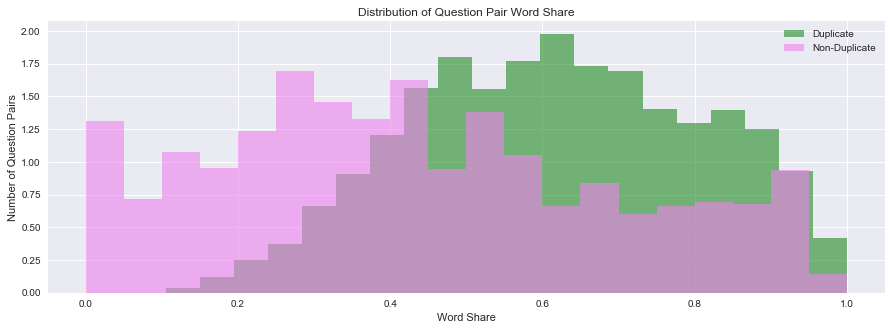

In [30]:
# Base
TRAIN_word_share_base = TRAIN_preprocessed.apply(lambda x: calculate_word_share(x['base_1'], x['base_2']), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_word_share_base[train_df.is_duplicate == 1], bins=20, color=('forestgreen'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_word_share_base[train_df.is_duplicate == 0], bins=20, color=('violet'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share')
plt.legend()
plt.show()

TRAIN_word_share_base.to_pickle('TRAIN_word_share_base.pkl')

del TRAIN_word_share_base

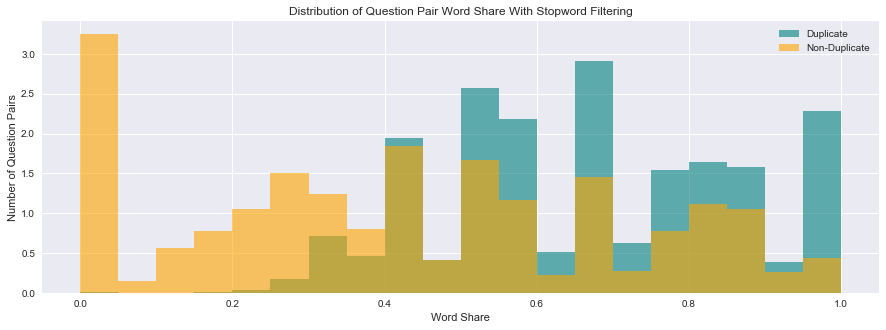

In [31]:
# Stopword filtering
TRAIN_word_share_filtered = TRAIN_preprocessed.apply(lambda x: calculate_word_share(x['filtered_1'], x['filtered_2']), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_word_share_filtered[train_df.is_duplicate == 1], bins=20, color=('teal'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_word_share_filtered[train_df.is_duplicate == 0], bins=20, color=('orange'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share With Stopword Filtering')
plt.legend()
plt.show()

TRAIN_word_share_filtered.to_pickle('TRAIN_word_share_filtered.pkl')

del TRAIN_word_share_filtered

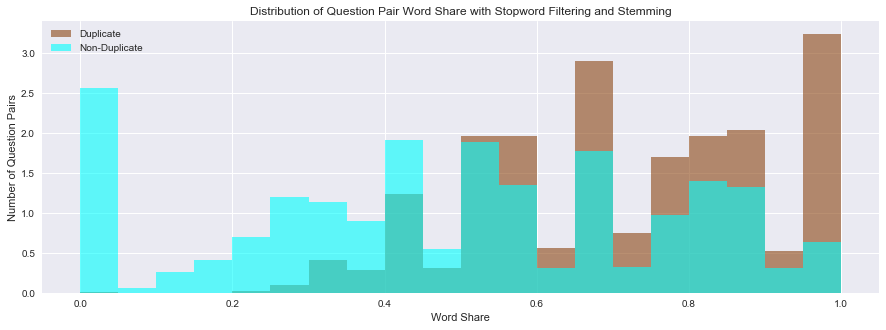

In [32]:
# Stopword filtering and stemming
TRAIN_word_share_stemmed_filtered = TRAIN_preprocessed.apply(lambda x: calculate_word_share(x['stemmed_filtered_1'], x['stemmed_filtered_2']), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_word_share_stemmed_filtered[train_df.is_duplicate == 1], bins=20, color=('saddlebrown'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_word_share_stemmed_filtered[train_df.is_duplicate == 0], bins=20, color=('cyan'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share with Stopword Filtering and Stemming')
plt.legend()
plt.show()

TRAIN_word_share_stemmed_filtered.to_pickle('TRAIN_word_share_stemmed_filtered.pkl')

del TRAIN_word_share_stemmed_filtered

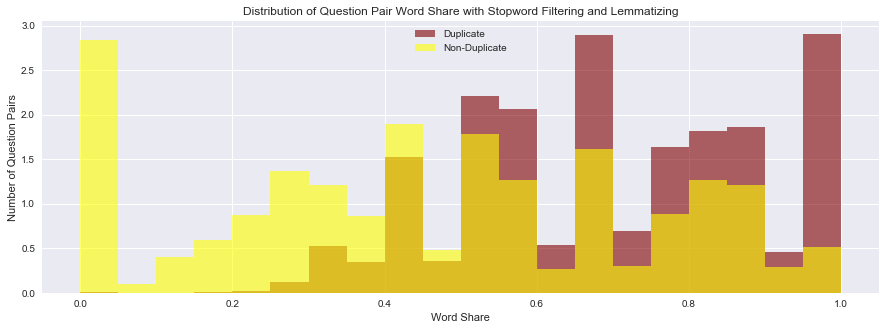

In [33]:
# Stopword filtering and lemmatizing
TRAIN_word_share_lemmatized_filtered = TRAIN_preprocessed.apply(lambda x: calculate_word_share(x['lemmatized_filtered_1'], x['lemmatized_filtered_2']), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(TRAIN_word_share_lemmatized_filtered[train_df.is_duplicate == 1], bins=20, color=('maroon'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(TRAIN_word_share_lemmatized_filtered[train_df.is_duplicate == 0], bins=20, color=('yellow'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share with Stopword Filtering and Lemmatizing')
plt.legend()
plt.show()

TRAIN_word_share_lemmatized_filtered.to_pickle('TRAIN_word_share_lemmatized_filtered.pkl')

del TRAIN_word_share_lemmatized_filtered

In [34]:
# Stemming
TRAIN_word_share_stemmed = TRAIN_preprocessed.apply(lambda x: calculate_word_share(x['stemmed_1'], x['stemmed_2']), axis=1, raw=True)
TRAIN_word_share_stemmed.to_pickle('TRAIN_word_share_stemmed.pkl')

# Lemmatizing
TRAIN_word_share_lemmatized = TRAIN_preprocessed.apply(lambda x: calculate_word_share(x['lemmatized_1'], x['lemmatized_2']), axis=1, raw=True)
TRAIN_word_share_lemmatized.to_pickle('TRAIN_word_share_lemmatized.pkl')

In [35]:
# Combine metrics into single dataframe
df = pd.DataFrame()
df['pid'] = TRAIN_preprocessed.pid
df['base'] = pd.read_pickle('TRAIN_word_share_base.pkl')
df['filtered'] = pd.read_pickle('TRAIN_word_share_filtered.pkl')
df['stemmed'] = pd.read_pickle('TRAIN_word_share_stemmed.pkl')
df['stemmed_filtered'] = pd.read_pickle('TRAIN_word_share_stemmed_filtered.pkl')
df['lemmatized'] = pd.read_pickle('TRAIN_word_share_lemmatized.pkl')
df['lemmatized_filtered'] = pd.read_pickle('TRAIN_word_share_lemmatized_filtered.pkl')
df.to_pickle('TRAIN_word_share.pkl')



In [36]:
df

,pid,base,filtered,stemmed,stemmed_filtered,lemmatized,lemmatized_filtered
0,0,0.961538,0.923077,0.961538,0.923077,0.961538,0.923077
1,1,0.600000,0.533333,0.600000,0.533333,0.600000,0.533333
2,2,0.333333,0.363636,0.416667,0.545455,0.333333,0.363636
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.400000,0.266667,0.400000,0.266667,0.400000,0.266667
5,5,0.676471,0.600000,0.676471,0.600000,0.676471,0.600000
6,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,7,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
8,8,0.800000,0.666667,0.800000,0.666667,0.800000,0.666667
9,9,0.444444,0.545455,0.444444,0.545455,0.444444,0.545455


# Pre Processing using TF-IDF algorithm

In [38]:
#Pre Processing using TF-IDF algorithm
TRAIN_preprocessed_stacked = pd.read_pickle('TRAIN_preprocessed_stacked.pkl')
vectorizer = TfidfVectorizer()

# Base
TDX = vectorizer.fit_transform(TRAIN_preprocessed_stacked.base.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('TRAIN_tfidf_weights_base.pkl', 'wb'))

# Filtered
TDX = vectorizer.fit_transform(TRAIN_preprocessed_stacked.filtered.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('TRAIN_tfidf_weights_filtered.pkl', 'wb'))

# Stemmed
TDX = vectorizer.fit_transform(TRAIN_preprocessed_stacked.stemmed.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('TRAIN_tfidf_weights_stemmed.pkl', 'wb'))

# Stemmed & Filtered
TDX = vectorizer.fit_transform(TRAIN_preprocessed_stacked.stemmed_filtered.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('TRAIN_tfidf_weights_stemmed_filtered.pkl', 'wb'))

# Lemmatized
TDX = vectorizer.fit_transform(TRAIN_preprocessed_stacked.lemmatized.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('TRAIN_tfidf_weights_lemmatized.pkl', 'wb'))

# Lemmatized & Filtered
TDX = vectorizer.fit_transform(TRAIN_preprocessed_stacked.lemmatized_filtered.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('TRAIN_tfidf_weights_lemmatized_filtered.pkl', 'wb'))

#del TRAIN_preprocessed_stacked, vectorizer, TDX, weights

In [39]:
TRAIN_preprocessed_unstacked = pd.read_pickle('TRAIN_preprocessed_unstacked.pkl')

In [40]:
#calculating word-share for TF-IDF
weights = pickle.load(open('TRAIN_tfidf_weights_base.pkl', 'rb'))
TRAIN_tfidf_word_share_base = TRAIN_preprocessed_unstacked.apply(lambda x: calculate_word_share(x['base_1'], x['base_2'], weights), axis=1, raw=True)
TRAIN_tfidf_word_share_base.to_pickle('TRAIN_tfidf_word_share_base.pkl')

weights = pickle.load(open('TRAIN_tfidf_weights_filtered.pkl', 'rb'))
TRAIN_tfidf_word_share_filtered = TRAIN_preprocessed_unstacked.apply(lambda x: calculate_word_share(x['filtered_1'], x['filtered_2'], weights), axis=1, raw=True)
TRAIN_tfidf_word_share_filtered.to_pickle('TRAIN_tfidf_word_share_filtered.pkl')

weights = pickle.load(open('TRAIN_tfidf_weights_stemmed.pkl', 'rb'))
TRAIN_tfidf_word_share_stemmed = TRAIN_preprocessed_unstacked.apply(lambda x: calculate_word_share(x['stemmed_1'], x['stemmed_2'], weights), axis=1, raw=True)

TRAIN_tfidf_word_share_stemmed.to_pickle('TRAIN_tfidf_word_share_stemmed.pkl')


weights = pickle.load(open('TRAIN_tfidf_weights_stemmed_filtered.pkl', 'rb'))
TRAIN_tfidf_word_share_stemmed_filtered = TRAIN_preprocessed_unstacked.apply(lambda x: calculate_word_share(x['stemmed_filtered_1'], x['stemmed_filtered_2'], weights), axis=1, raw=True)


TRAIN_tfidf_word_share_stemmed_filtered.to_pickle('TRAIN_tfidf_word_share_stemmed_filtered.pkl')

weights = pickle.load(open('TRAIN_tfidf_weights_lemmatized.pkl', 'rb'))
TRAIN_tfidf_word_share_lemmatized = TRAIN_preprocessed_unstacked.apply(lambda x: calculate_word_share(x['lemmatized_1'], x['lemmatized_2'], weights), axis=1, raw=True)


TRAIN_tfidf_word_share_lemmatized.to_pickle('TRAIN_tfidf_word_share_lemmatized.pkl')


weights = pickle.load(open('TRAIN_tfidf_weights_lemmatized_filtered.pkl', 'rb'))
TRAIN_tfidf_word_share_lemmatized_filtered = TRAIN_preprocessed_unstacked.apply(lambda x: calculate_word_share(x['lemmatized_filtered_1'], x['lemmatized_filtered_2'], weights), axis=1, raw=True)


TRAIN_tfidf_word_share_lemmatized_filtered.to_pickle('TRAIN_tfidf_word_share_lemmatized_filtered.pkl')

#del weights, TRAIN_tfidf_word_share_base

In [41]:
# Combine metrics into single dataframe
df = pd.DataFrame()
df['pid'] = TRAIN_preprocessed_unstacked.pid
df['base'] = pd.read_pickle('TRAIN_tfidf_word_share_base.pkl')
df['filtered'] = pd.read_pickle('TRAIN_tfidf_word_share_filtered.pkl')
df['stemmed'] = pd.read_pickle('TRAIN_tfidf_word_share_stemmed.pkl')
df['stemmed_filtered'] = pd.read_pickle('TRAIN_tfidf_word_share_stemmed_filtered.pkl')
df['lemmatized'] = pd.read_pickle('TRAIN_tfidf_word_share_lemmatized.pkl')
df['lemmatized_filtered'] = pd.read_pickle('TRAIN_tfidf_word_share_lemmatized_filtered.pkl')
df.to_pickle('TRAIN_tfidf_word_share.pkl')


In [42]:
df.head()

,pid,base,filtered,stemmed,stemmed_filtered,lemmatized,lemmatized_filtered
0,0,0.967216,0.955711,0.965081,0.951720,0.966132,0.953706
1,1,0.642302,0.658069,0.637580,0.653398,0.643105,0.659143
2,2,0.303168,0.322098,0.427299,0.511466,0.303350,0.322433
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.296778,0.233401,0.300812,0.236593,0.296648,0.233008


# TRAINING
# Train-Validate-Test Split

In [3]:
TRAIN_word_share = pd.read_pickle('TRAIN_word_share.pkl')
TRAIN_tfidf_word_share = pd.read_pickle('TRAIN_tfidf_word_share.pkl')


X_train = pd.DataFrame()
X_train['word_share_base'] = TRAIN_word_share.base
X_train['word_share_filtered'] = TRAIN_word_share.filtered
X_train['word_share_stemmed'] = TRAIN_word_share.stemmed
X_train['word_share_stemmed_filtered'] = TRAIN_word_share.stemmed_filtered
X_train['word_share_lemmatized'] = TRAIN_word_share.lemmatized
X_train['word_share_lemmatized_filtered'] = TRAIN_word_share.lemmatized
X_train['tfidf_word_share_base'] = TRAIN_tfidf_word_share.base
X_train['tfidf_word_share_filtered'] = TRAIN_tfidf_word_share.filtered
X_train['tfidf_word_share_stemmed'] = TRAIN_tfidf_word_share.stemmed
X_train['tfidf_word_share_stemmed_filtered'] = TRAIN_tfidf_word_share.stemmed_filtered
X_train['tfidf_word_share_lemmatized'] = TRAIN_tfidf_word_share.lemmatized
X_train['tfidf_word_share_lemmatized_filtered'] = TRAIN_tfidf_word_share.lemmatized_filtered

y_train = train_df.is_duplicate.values

#del TRAIN_word_share, TRAIN_tfidf_word_share, TRAIN_d2v_cos_sim

In [52]:
X_train

,word_share_base,word_share_filtered,word_share_stemmed,word_share_stemmed_filtered,word_share_lemmatized,word_share_lemmatized_filtered,tfidf_word_share_base,tfidf_word_share_filtered,tfidf_word_share_stemmed,tfidf_word_share_stemmed_filtered,tfidf_word_share_lemmatized,tfidf_word_share_lemmatized_filtered
0,0.961538,0.923077,0.961538,0.923077,0.961538,0.961538,0.967216,0.955711,0.965081,0.951720,0.966132,0.953706
1,0.600000,0.533333,0.600000,0.533333,0.600000,0.600000,0.642302,0.658069,0.637580,0.653398,0.643105,0.659143
2,0.333333,0.363636,0.416667,0.545455,0.333333,0.333333,0.303168,0.322098,0.427299,0.511466,0.303350,0.322433
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.400000,0.266667,0.400000,0.266667,0.400000,0.400000,0.296778,0.233401,0.300812,0.236593,0.296648,0.233008
5,0.676471,0.600000,0.676471,0.600000,0.676471,0.676471,0.598645,0.565110,0.605538,0.573685,0.598278,0.564163
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.546020,0.693170,0.537617,0.685981,0.539291,0.685632
8,0.800000,0.666667,0.800000,0.666667,0.800000,0.800000,0.946059,1.000000,0.944430,1.000000,0.946058,1.000000
9,0.444444,0.545455,0.444444,0.545455,0.444444,0.444444,0.514947,0.586575,0.518351,0.592685,0.514717,0.587117


In [4]:
# Validation Set
#Spliting of training dataset into 80% training data and 20% testing data randomly
X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=52)

In [54]:
#Because our label is of binary value we have choosen LogisticRegression
#Initial Training with Grid Search and Cross Validation
#Don't Run it will take around 2hrs 

cores = mp.cpu_count() - 1

params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,10,2)
}

xgb_model = xgb.XGBClassifier(
 learning_rate=0.1,
 n_estimators=1000,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 seed=27)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='neg_log_loss', cv=4, verbose=10)

grid_search.fit(X_training, y_training)

grid_search.grid_scores_, grid_search.best_params_, grid_search.best_score_

C:\Users\legen\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV] max_depth=3, min_child_weight=1 .................................
[CV] . max_depth=3, min_child_weight=1, score=-0.478752, total=  34.4s
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.8s remaining:    0.0s


[CV] . max_depth=3, min_child_weight=1, score=-0.479349, total=  34.1s
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] . max_depth=3, min_child_weight=1, score=-0.477883, total=  35.7s
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.8min remaining:    0.0s


[CV] . max_depth=3, min_child_weight=1, score=-0.475452, total=  36.3s
[CV] max_depth=3, min_child_weight=3 .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.4min remaining:    0.0s


[CV] . max_depth=3, min_child_weight=3, score=-0.478972, total=  36.7s
[CV] max_depth=3, min_child_weight=3 .................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.1min remaining:    0.0s


[CV] . max_depth=3, min_child_weight=3, score=-0.479465, total=  37.7s
[CV] max_depth=3, min_child_weight=3 .................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.7min remaining:    0.0s


[CV] . max_depth=3, min_child_weight=3, score=-0.477554, total=  36.5s
[CV] max_depth=3, min_child_weight=3 .................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.4min remaining:    0.0s


[CV] . max_depth=3, min_child_weight=3, score=-0.475396, total=  36.7s
[CV] max_depth=3, min_child_weight=5 .................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  5.0min remaining:    0.0s


[CV] . max_depth=3, min_child_weight=5, score=-0.478892, total=  37.9s
[CV] max_depth=3, min_child_weight=5 .................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  5.7min remaining:    0.0s


[CV] . max_depth=3, min_child_weight=5, score=-0.479102, total=  37.5s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] . max_depth=3, min_child_weight=5, score=-0.477525, total=  38.1s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] . max_depth=3, min_child_weight=5, score=-0.475268, total=  39.1s
[CV] max_depth=3, min_child_weight=7 .................................
[CV] . max_depth=3, min_child_weight=7, score=-0.478431, total=  37.4s
[CV] max_depth=3, min_child_weight=7 .................................
[CV] . max_depth=3, min_child_weight=7, score=-0.479524, total=  37.5s
[CV] max_depth=3, min_child_weight=7 .................................
[CV] . max_depth=3, min_child_weight=7, score=-0.477493, total=  38.4s
[CV] max_depth=3, min_child_weight=7 .................................
[CV] . max_depth=3, min_child_weight=7, score=-0.475282, total=  39.4s
[CV] max_depth=3, min_child_weight=9 .................................
[CV] .

[CV] . max_depth=9, min_child_weight=3, score=-0.473218, total= 1.7min
[CV] max_depth=9, min_child_weight=5 .................................
[CV] . max_depth=9, min_child_weight=5, score=-0.476058, total= 1.7min
[CV] max_depth=9, min_child_weight=5 .................................
[CV] . max_depth=9, min_child_weight=5, score=-0.478808, total= 1.7min
[CV] max_depth=9, min_child_weight=5 .................................
[CV] . max_depth=9, min_child_weight=5, score=-0.475281, total= 1.7min
[CV] max_depth=9, min_child_weight=5 .................................
[CV] . max_depth=9, min_child_weight=5, score=-0.473362, total= 1.7min
[CV] max_depth=9, min_child_weight=7 .................................
[CV] . max_depth=9, min_child_weight=7, score=-0.476264, total= 1.7min
[CV] max_depth=9, min_child_weight=7 .................................
[CV] . max_depth=9, min_child_weight=7, score=-0.477358, total= 1.7min
[CV] max_depth=9, min_child_weight=7 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 97.9min finished
C:\Users\legen\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.47786, std: 0.00148, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.47785, std: 0.00158, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.47770, std: 0.00153, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.47768, std: 0.00156, params: {'max_depth': 3, 'min_child_weight': 7},
  mean: -0.47773, std: 0.00165, params: {'max_depth': 3, 'min_child_weight': 9},
  mean: -0.47394, std: 0.00164, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.47387, std: 0.00168, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.47397, std: 0.00174, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.47412, std: 0.00163, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: -0.47397, std: 0.00172, params: {'max_depth': 5, 'min_child_weight': 9},
  mean: -0.47436, std: 0.00168, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.47407, std: 0.00180, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.47385, std: 0.001

## Building a Model with different Classifier

In [21]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=23)
clf.fit(X_training, y_training)
prediction = clf.predict(X_validation)
y_pred_prob = clf.predict_proba(X_validation)[:,1]

print ("Accuracy:")
print (accuracy_score(prediction, y_validation))
print ("Classification Report:")
print (classification_report(prediction, y_validation))
print ("Confusion Matrix:")
print (confusion_matrix(prediction, y_validation))
print ("ROC_AUC_% :")
print (roc_auc_score(y_validation,y_pred_prob))


Accuracy:
0.666761483094
Classification Report:
             precision    recall  f1-score   support

          0       0.79      0.71      0.75     56819
          1       0.45      0.56      0.50     24039

avg / total       0.69      0.67      0.68     80858

Confusion Matrix:
[[40467 16352]
 [10593 13446]]
ROC_AUC_% :
0.752404119255


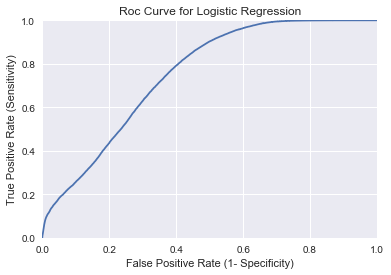

In [22]:
#ROC_Curve for Random Forest 

fpr , tpr, thersholds = roc_curve(y_validation,y_pred_prob)
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.title("Roc Curve for Logistic Regression")
plt.xlabel("False Positive Rate (1- Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.grid(True)

##### ROC curve we help to choose a threshold that balance sensitivity and specificity in away that makes sense for our project context.

In [29]:
#Because our label is of binary value we have choosen LogisticRegression
#Initial Training with Grid Search and Cross Validation
#Don't Run it will take around 2hrs
#With Accuracy as measure
cores = mp.cpu_count() - 1

params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,10,2)
}

xgb_model = xgb.XGBClassifier(
 learning_rate=0.1,
 n_estimators=1000,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 seed=27)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=4, verbose=10)

grid_search.fit(X_training, y_training)

grid_search.grid_scores_, grid_search.best_params_, grid_search.best_score_

prediction = grid_search.predict(X_validation)

prob = grid_search.predict_proba(X_validation)
print ("Accuracy:")
print (accuracy_score(prediction, y_validation))
print ("Classification Report:")
print (classification_report(prediction, y_validation))
print ("Confusion Matrix:")
print (confusion_matrix(prediction, y_validation))

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .. max_depth=3, min_child_weight=1, score=0.725695, total=  38.4s
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.9s remaining:    0.0s


[CV] .. max_depth=3, min_child_weight=1, score=0.727164, total=  42.9s
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV] .. max_depth=3, min_child_weight=1, score=0.727757, total=  39.4s
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.1min remaining:    0.0s


[CV] .. max_depth=3, min_child_weight=1, score=0.731229, total=  36.6s
[CV] max_depth=3, min_child_weight=3 .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.7min remaining:    0.0s


[CV] .. max_depth=3, min_child_weight=3, score=0.725745, total=  36.9s
[CV] max_depth=3, min_child_weight=3 .................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.4min remaining:    0.0s


[CV] .. max_depth=3, min_child_weight=3, score=0.726657, total=  42.9s
[CV] max_depth=3, min_child_weight=3 .................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.1min remaining:    0.0s


[CV] .. max_depth=3, min_child_weight=3, score=0.727906, total=  38.6s
[CV] max_depth=3, min_child_weight=3 .................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.8min remaining:    0.0s


[CV] .. max_depth=3, min_child_weight=3, score=0.730697, total=  37.0s
[CV] max_depth=3, min_child_weight=5 .................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  5.4min remaining:    0.0s


[CV] .. max_depth=3, min_child_weight=5, score=0.726376, total=  37.5s
[CV] max_depth=3, min_child_weight=5 .................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  6.1min remaining:    0.0s


[CV] .. max_depth=3, min_child_weight=5, score=0.727176, total=  36.8s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] .. max_depth=3, min_child_weight=5, score=0.727188, total=  36.9s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] .. max_depth=3, min_child_weight=5, score=0.731130, total=  36.8s
[CV] max_depth=3, min_child_weight=7 .................................
[CV] .. max_depth=3, min_child_weight=7, score=0.725139, total=  36.9s
[CV] max_depth=3, min_child_weight=7 .................................
[CV] .. max_depth=3, min_child_weight=7, score=0.727757, total=  37.2s
[CV] max_depth=3, min_child_weight=7 .................................
[CV] .. max_depth=3, min_child_weight=7, score=0.727423, total=  37.1s
[CV] max_depth=3, min_child_weight=7 .................................
[CV] .. max_depth=3, min_child_weight=7, score=0.731031, total=  37.0s
[CV] max_depth=3, min_child_weight=9 .................................
[CV] .

[CV] .. max_depth=9, min_child_weight=3, score=0.733925, total= 1.6min
[CV] max_depth=9, min_child_weight=5 .................................
[CV] .. max_depth=9, min_child_weight=5, score=0.729171, total= 1.6min
[CV] max_depth=9, min_child_weight=5 .................................
[CV] .. max_depth=9, min_child_weight=5, score=0.731579, total= 1.6min
[CV] max_depth=9, min_child_weight=5 .................................
[CV] .. max_depth=9, min_child_weight=5, score=0.730070, total= 1.6min
[CV] max_depth=9, min_child_weight=5 .................................
[CV] .. max_depth=9, min_child_weight=5, score=0.732627, total= 1.6min
[CV] max_depth=9, min_child_weight=7 .................................
[CV] .. max_depth=9, min_child_weight=7, score=0.732510, total= 1.6min
[CV] max_depth=9, min_child_weight=7 .................................
[CV] .. max_depth=9, min_child_weight=7, score=0.730960, total= 1.6min
[CV] max_depth=9, min_child_weight=7 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 96.6min finished
C:\Users\legen\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Accuracy:
0.735301392565
Classification Report:
             precision    recall  f1-score   support

          0       0.77      0.80      0.79     49129
          1       0.67      0.63      0.65     31729

avg / total       0.73      0.74      0.73     80858

Confusion Matrix:
[[39393  9736]
 [11667 20062]]


#### Feature Importance & Pruning

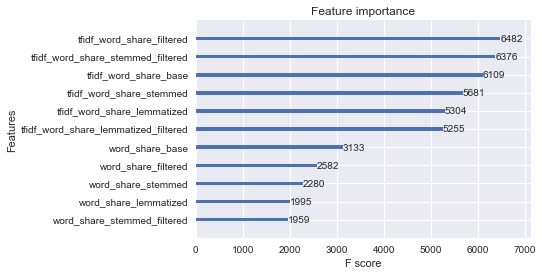

In [30]:
xgb.plot_importance(grid_search.best_estimator_)

Features  (word_share_stemmed_filtered) and  (word_share_lemmatized) were identified as least important.

In [15]:
X_training_pruned = pd.DataFrame(X_training).drop(pd.DataFrame(X_training).columns[[3, 4]], axis=1)
X_validation_pruned = pd.DataFrame(X_validation).drop(pd.DataFrame(X_validation).columns[[3, 4]], axis=1)

In [13]:
### Decision Tree 

from sklearn import tree
clf = tree.DecisionTreeClassifier()
model=clf.fit(X_training, y_training)
prediction = clf.predict(X_validation)
y_pred_prob = clf.predict_proba(X_validation)[:,1]


print ("Accuracy:")
print (accuracy_score(prediction, y_validation))
print ("Classification Report:")
print (classification_report(prediction, y_validation))
print ("Confusion Matrix:")
print (confusion_matrix(prediction, y_validation))
print ("ROC_AUC_% :")
print (roc_auc_score(y_validation,y_pred_prob))



Accuracy:
0.683865542061
Classification Report:
             precision    recall  f1-score   support

          0       0.75      0.75      0.75     50808
          1       0.58      0.57      0.57     30050

avg / total       0.68      0.68      0.68     80858

Confusion Matrix:
[[38153 12655]
 [12907 17143]]
ROC_AUC_% :
0.659563544224


In [9]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_training, y_training)
prediction = clf.predict(X_validation)


print ("Accuracy:")
print (accuracy_score(prediction, y_validation))
print ("Classification Report:")
print (classification_report(prediction, y_validation))
print ("Confusion Matrix:")
print (confusion_matrix(prediction, y_validation))
print ("ROC_AUC_% :")
print (roc_auc_score(y_validation,y_pred_prob))


Accuracy:
0.676222513542
Classification Report:
             precision    recall  f1-score   support

          0       0.62      0.82      0.71     38584
          1       0.77      0.54      0.64     42274

avg / total       0.70      0.68      0.67     80858

Confusion Matrix:
[[31732  6852]
 [19328 22946]]


In [17]:
#Random Forest 
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
model=clf.fit(X_training, y_training)
prediction = clf.predict(X_validation)
y_pred_prob = clf.predict_proba(X_validation)[:,1]

print ("Accuracy:")
print (accuracy_score(prediction, y_validation))
print ("Classification Report:")
print (classification_report(prediction, y_validation))
print ("Confusion Matrix:")
print (confusion_matrix(prediction, y_validation))
print ("ROC_AUC_% :")
print (roc_auc_score(y_validation,y_pred_prob))



Accuracy:
0.729872121497
Classification Report:
             precision    recall  f1-score   support

          0       0.79      0.78      0.79     51760
          1       0.62      0.64      0.63     29098

avg / total       0.73      0.73      0.73     80858

Confusion Matrix:
[[40489 11271]
 [10571 18527]]
ROC_AUC_% :
0.81641253023


##### Here we got ROC_AUC_Score as 81% which is good model for predicting True Positive Values.

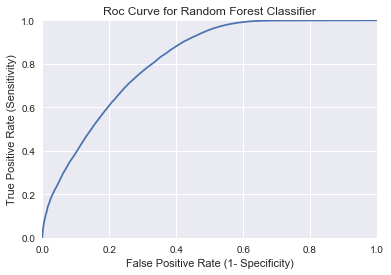

In [20]:
#ROC_Curve for Random Forest 

fpr , tpr, thersholds = roc_curve(y_validation,y_pred_prob)
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.title("Roc Curve for Random Forest Classifier")
plt.xlabel("False Positive Rate (1- Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.grid(True)

In [10]:
#Nearest Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=30)
clf.fit(X_training_pruned, y_training)
prediction = clf.predict(X_validation_pruned)
print ("Accuracy:")
print (accuracy_score(prediction, y_validation))
print ("Classification Report:")
print (classification_report(prediction, y_validation))
print ("Confusion Matrix:")
print (confusion_matrix(prediction, y_validation))


Accuracy:
0.721004724332
Classification Report:
             precision    recall  f1-score   support

          0       0.80      0.77      0.78     53327
          1       0.58      0.63      0.61     27531

avg / total       0.73      0.72      0.72     80858

Confusion Matrix:
[[40914 12413]
 [10146 17385]]


In [11]:
#Extra Tree
from sklearn.ensemble import  ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=100, n_jobs=-1,random_state=29)
clf.fit(X_training_pruned, y_training)
prediction = clf.predict(X_validation_pruned)
print ("Accuracy:")
print (accuracy_score(prediction, y_validation))
print ("Classification Report:")
print (classification_report(prediction, y_validation))
print ("Confusion Matrix:")
print (confusion_matrix(prediction, y_validation))

Accuracy:
0.723441094264
Classification Report:
             precision    recall  f1-score   support

          0       0.79      0.77      0.78     52196
          1       0.61      0.63      0.62     28662

avg / total       0.73      0.72      0.72     80858

Confusion Matrix:
[[40447 11749]
 [10613 18049]]


# Conclusion
## After using Different classifiers the result of measure: Accuracy is
#### LogisticRegression (XGboost) : 0.736162
#### Decision Tree :0.686561626555
#### Gaussian Naive Bayes :0.729971060377
#### Random Forest :0.730119468698
#### Nearest Neighbors Classifier :0.723960523387
#### Extra Trees Classifier :0.726236117638

#### So we can see that "Random forest"  and "Logistic Regression With Boosting" gives the more accuracy for our classification dataset
#### We choose Random Forest over Logistic Regression because Random forest is easy to tune and harder to overfit. 


### Here were Spliting the data set into 75% and 25% and building a model with different classifiers with changing parameters  

In [23]:
# Validation Set
#Spliting of training dataset into 75% training data and 25% testing data randomly
X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=32)

In [24]:
#Random Forest 
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
model=clf.fit(X_training, y_training)
prediction = clf.predict(X_validation)
y_pred_prob = clf.predict_proba(X_validation)[:,1]

print ("Accuracy:")
print (accuracy_score(prediction, y_validation))
print ("Classification Report:")
print (classification_report(prediction, y_validation))
print ("Confusion Matrix:")
print (confusion_matrix(prediction, y_validation))
print ("ROC_AUC_% :")
print (roc_auc_score(y_validation,y_pred_prob))



Accuracy:
0.726346304156
Classification Report:
             precision    recall  f1-score   support

          0       0.79      0.78      0.79     64960
          1       0.61      0.63      0.62     36113

avg / total       0.73      0.73      0.73    101073

Confusion Matrix:
[[50668 14292]
 [13367 22746]]
ROC_AUC_% :
0.812254313714


In [25]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=23)
clf.fit(X_training, y_training)
prediction = clf.predict(X_validation)
y_pred_prob = clf.predict_proba(X_validation)[:,1]

print ("Accuracy:")
print (accuracy_score(prediction, y_validation))
print ("Classification Report:")
print (classification_report(prediction, y_validation))
print ("Confusion Matrix:")
print (confusion_matrix(prediction, y_validation))
print ("ROC_AUC_% :")
print (roc_auc_score(y_validation,y_pred_prob))


Accuracy:
0.666043354803
Classification Report:
             precision    recall  f1-score   support

          0       0.79      0.71      0.75     70533
          1       0.46      0.55      0.50     30540

avg / total       0.69      0.67      0.67    101073

Confusion Matrix:
[[50407 20126]
 [13628 16912]]
ROC_AUC_% :
0.750506181288


In [14]:
#Nearest Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=30)
clf.fit(X_training, y_training)
prediction = clf.predict(X_validation)
print ("Accuracy:")
print (accuracy_score(prediction, y_validation))
print ("Classification Report:")
print (classification_report(prediction, y_validation))
print ("Confusion Matrix:")
print (confusion_matrix(prediction, y_validation))

Accuracy:
0.719737219633
Classification Report:
             precision    recall  f1-score   support

          0       0.80      0.77      0.78     66494
          1       0.58      0.63      0.60     34579

avg / total       0.72      0.72      0.72    101073

Confusion Matrix:
[[51101 15393]
 [12934 21645]]


In [16]:
#Extra Tree
from sklearn.ensemble import  ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=100, n_jobs=-1,random_state=29)
clf.fit(X_training, y_training)
prediction = clf.predict(X_validation)
print ("Accuracy:")
print (accuracy_score(prediction, y_validation))
print ("Classification Report:")
print (classification_report(prediction, y_validation))
print ("Confusion Matrix:")
print (confusion_matrix(prediction, y_validation))

Accuracy:
0.719786688829
Classification Report:
             precision    recall  f1-score   support

          0       0.79      0.77      0.78     65095
          1       0.60      0.62      0.61     35978

avg / total       0.72      0.72      0.72    101073

Confusion Matrix:
[[50404 14691]
 [13631 22347]]


###### After spliting dataset and changing parameters of  algorithmalso we dont find much change in the accuracy of the different classifiers.

## Test Set Preparation  & Predictions

In [ ]:
# Combine preprocessed text into a stacked dataframe
df = pd.DataFrame()
df['pid'] = TEST.test_id.append(TEST.test_id)
df['qid'] = pd.Series(np.arange(len(TEST) * 2))
df['base'] = pd.read_pickle('./pickles.gi/TEST_tokenized.pkl')
df['filtered'] = pd.read_pickle('./pickles.gi/TEST_filtered.pkl')
df['stemmed'] = pd.read_pickle('./pickles.gi/TEST_stemmed.pkl')
df['stemmed_filtered'] = pd.read_pickle('./pickles.gi/TEST_stemmed_filtered.pkl')
df['lemmatized'] = pd.read_pickle('./pickles.gi/TEST_lemmatized.pkl')
df['lemmatized_filtered'] = pd.read_pickle('./pickles.gi/TEST_lemmatized_filtered.pkl')
df.to_pickle('./pickles.gi/TEST_preprocessed_stacked.pkl')

# Create unstacked version of preprocessed dataframe
df = pd.read_pickle('./pickles.gi/TEST_preprocessed_stacked.pkl')
df = df.merge(df, how='inner', on='pid', suffixes=('_1','_2'))
df = df[(df['qid_1'] != df['qid_2']) & (df['qid_1'] < df['qid_1'])]
df.reset_index(drop=True, inplace=True)
df.to_pickle('./pickles.gi/TEST_preprocessed_unstacked.pkl')

# Tagging for Doc2Vec processing
preprocessed_stacked = pd.read_pickle('./pickles.gi/TEST_preprocessed_unstacked.pkl')
df = pd.DataFrame()
df['pid'] = preprocessed_stacked.pid
df['qid'] = preprocessed_stacked.qid
df['base'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['base'], [x['qid']]), axis=1)
df['filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['filtered'], [x['qid']]), axis=1)
df['stemmed'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['stemmed'], [x['qid']]), axis=1)
df['stemmed_filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['stemmed_filtered'], [x['qid']]), axis=1)
df['lemmatized'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['lemmatized'], [x['qid']]), axis=1)
df['lemmatized_filtered'] = preprocessed_stacked.apply(lambda x: d2v.TaggedDocument(x['lemmatized_filtered'], [x['qid']]), axis=1)
df.reset_index(drop=True, inplace=True)
df.to_pickle('./pickles.gi/TEST_tagged.pkl')

# Word share
TEST_word_share_base = TEST_preprocessed.apply(lambda x: calculate_word_share(x['base_1'], x['base_2']), axis=1, raw=True)
TEST_word_share_filtered = TEST_preprocessed.apply(lambda x: calculate_word_share(x['filtered_1'], x['filtered_2']), axis=1, raw=True)
TEST_word_share_stemmed = TEST_preprocessed.apply(lambda x: calculate_word_share(x['stemmed_1'], x['stemmed_2']), axis=1, raw=True)
TEST_word_share_stemmed_filtered = TEST_preprocessed.apply(lambda x: calculate_word_share(x['stemmed_filtered_1'], x['stemmed_filtered_2']), axis=1, raw=True)
TEST_word_share_lemmatized = TEST_preprocessed.apply(lambda x: calculate_word_share(x['lemmatized_1'], x['lemmatized_2']), axis=1, raw=True)
TEST_word_share_lemmatized_filtered = TEST_preprocessed.apply(lambda x: calculate_word_share(x['lemmatized_filtered_1'], x['lemmatized_filtered_2']), axis=1, raw=True)

# Combine word share metrics into single dataframe
df = pd.DataFrame()
df['pid'] = TEST_preprocessed.pid
df['base'] = pd.read_pickle('./pickles.gi/TEST_word_share_base.pkl')
df['filtered'] = pd.read_pickle('./pickles.gi/TEST_word_share_filtered.pkl')
df['stemmed'] = pd.read_pickle('./pickles.gi/TEST_word_share_stemmed.pkl')
df['stemmed_filtered'] = pd.read_pickle('./pickles.gi/TEST_word_share_stemmed_filtered.pkl')
df['lemmatized'] = pd.read_pickle('./pickles.gi/TEST_word_share_lemmatized.pkl')
df['lemmatized_filtered'] = pd.read_pickle('./pickles.gi/TEST_word_share_lemmatized_filtered.pkl')
df.to_pickle('./pickles.gi/TEST_word_share.pkl')

# TF-IDF
TEST_preprocessed_stacked = pd.read_pickle('./pickles.gi/TEST_preprocessed_stacked.pkl')
vectorizer = TfidfVectorizer()

# Base
TDX = vectorizer.fit_transform(TEST_preprocessed_stacked.base.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TEST_tfidf_weights_base.pkl', 'wb'))

# Filtered
TDX = vectorizer.fit_transform(TEST_preprocessed_stacked.filtered.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TEST_tfidf_weights_filtered.pkl', 'wb'))

# Stemmed
TDX = vectorizer.fit_transform(TEST_preprocessed_stacked.stemmed.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TEST_tfidf_weights_stemmed.pkl', 'wb'))

# Stemmed & Filtered
TDX = vectorizer.fit_transform(TEST_preprocessed_stacked.stemmed_filtered.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TEST_tfidf_weights_stemmed_filtered.pkl', 'wb'))

# Lemmatized
TDX = vectorizer.fit_transform(TEST_preprocessed_stacked.lemmatized.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TEST_tfidf_weights_lemmatized.pkl', 'wb'))

# Lemmatized & Filtered
TDX = vectorizer.fit_transform(TEST_preprocessed_stacked.lemmatized_filtered.fillna('').apply(lambda x: ' '.join(x)))
weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
pickle.dump(weights, open('./pickles.gi/TEST_tfidf_weights_lemmatized_filtered.pkl', 'wb'))

# Train Test Split
X_test = pd.DataFrame()
X_test['word_share_base'] = TRAIN_word_share.base
X_test['word_share_filtered'] = TRAIN_word_share.filtered
X_test['word_share_stemmed'] = TRAIN_word_share.stemmed
X_test['word_share_stemmed_filtered'] = TRAIN_word_share.stemmed_filtered
X_test['word_share_lemmatized'] = TRAIN_word_share.lemmatized
X_test['word_share_lemmatized_filtered'] = TRAIN_word_share.lemmatized
X_test['tfidf_word_share_base'] = TRAIN_tfidf_word_share.base
X_test['tfidf_word_share_filtered'] = TRAIN_tfidf_word_share.filtered
X_test['tfidf_word_share_stemmed'] = TRAIN_tfidf_word_share.stemmed
X_test['tfidf_word_share_stemmed_filtered'] = TRAIN_tfidf_word_share.stemmed_filtered
X_test['tfidf_word_share_lemmatized'] = TRAIN_tfidf_word_share.lemmatized
X_test['tfidf_word_share_lemmatized_filtered'] = TRAIN_tfidf_word_share.lemmatized_filtered
X_test['d2v_cos_sim_lemmatized_filtered'] = TRAIN_d2v_cos_sim.lemmatized_filtered

# Predict
d_test = xgb.DMatrix(pd.DataFrame(X_test).drop(pd.DataFrame(X_test).columns[[3, 4]], axis=1))
p_test = bst.predict(d_test)

